# TM10007 Assignment ECG - group 3

### Imports

In [1]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from itertools import combinations
from scipy.stats import ttest_rel, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc


### Data loading, save features and labels into dataframe 

In [2]:
with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data.label
X = data.drop('label', axis=1)

The number of samples: 827
The number of columns: 9001


# Constants

In [3]:
N_SPLITS = 5 # number of splits for outer validation loop
RANDOM_SEED = 42 # get reproducable splits for the different models

## PCA plot to visualize data

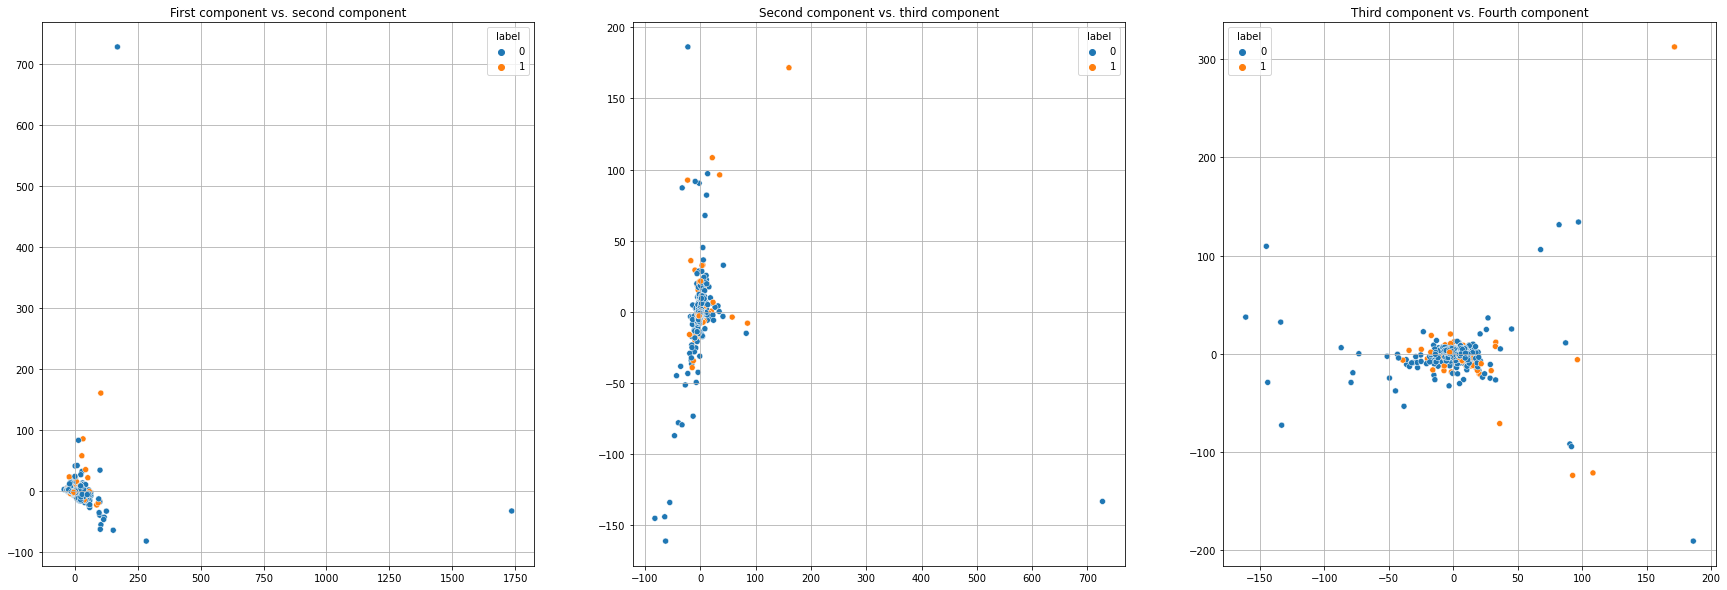

In [4]:
# PCA plot of all data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

fig, axs = plt.subplots(1, 3, figsize=(30,10))
seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=axs[0])
axs[0].set_title('First component vs. second component')
axs[0].grid()
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y, ax=axs[1])
axs[1].set_title('Second component vs. third component')
axs[1].grid()
seaborn.scatterplot(x=X_pca[:, 2], y=X_pca[:, 3], hue=y, ax=axs[2])
axs[2].set_title('Third component vs. Fourth component')
axs[2].grid()

(0.0, 75.0)

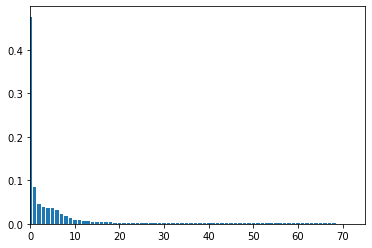

In [5]:
plt.bar(x=range(pca.explained_variance_ratio_.shape[0]), height=pca.explained_variance_ratio_)
plt.xlim([0, 75])

### Learning Curve function 

In [6]:
def plot_learning_curve(clf, X_train, y_train, plot):
    train_size, train_scores, test_scores = learning_curve(clf, X_train, y_train, scoring='roc_auc')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot.plot(train_size, train_mean, color='b', label='training')
    plot.plot(train_size, test_mean, color='orange', label='validation')

    plot.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plot.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plot.grid()
    plot.set_ylim([0.5, 1.1])
    plot.set_xlabel('Training examples')
    plot.set_ylabel('ROC-AUC Score')
    plot.legend()

# Random forest classifier 

### Loop of test-training  and evaluation loop

#### Training-Testing using k-best feature selection

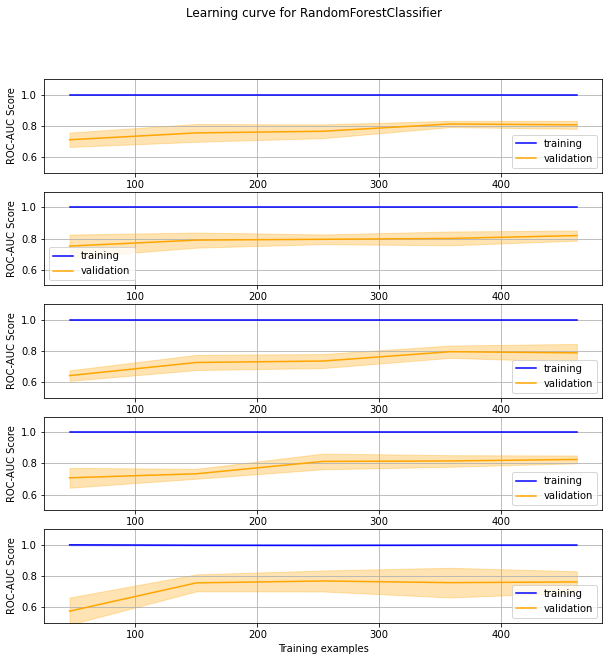

In [7]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_rf = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_rf = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('select', SelectKBest()), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap,
    #'pca__n_components': pca_components}
    'select__k': np.arange(2,150)}
 
    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_rf.append(search)


    # Evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_rf['f1'] += [f1_score(y_test, y_pred)]
    scores_rf['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_rf['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_rf[f'probs_split_{i+1}'] = y_score
    scores_rf[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

#### Training-Testing using Standard Scaler and PCA (hidden)
Performance for this pipeline was less compared to using the k-best feature selection (above).

In [ ]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_rf = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_rf = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap,
    'pca__n_components': pca_components}
 
    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', verbose=2, n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_rf.append(search)


    # Evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_rf['f1'] += [f1_score(y_test, y_pred)]
    scores_rf['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_rf['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_rf[f'probs_split_{i+1}'] = y_score
    scores_rf[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [8]:
print('F1-scores:')
print(f"{scores_rf['f1']}, mean: {np.mean(scores_rf['f1'])}, std: {np.std(scores_rf['f1'])}")
print('Accuracy:')
print(f"{scores_rf['accuracy']}, mean: {np.mean(scores_rf['accuracy'])}, std: {np.std(scores_rf['accuracy'])}")
print('AUC:')
print(f"{scores_rf['AUC']}, mean: {np.mean(scores_rf['AUC'])}, std: {np.std(scores_rf['AUC'])}")

F1-scores:
[0.3661971830985915, 0.45161290322580644, 0.22222222222222218, 0.28571428571428575, 0.30769230769230765], mean: 0.3266877803906427, std: 0.07761441529791475
Accuracy:
[0.8192771084337349, 0.8634538152610441, 0.8313253012048193, 0.8393574297188755, 0.8192771084337349], mean: 0.8345381526104418, std: 0.016342963814759682
AUC:
[0.7831485587583149, 0.7539911308203991, 0.7886917960088692, 0.7614190687361418, 0.6907982261640798], mean: 0.755609756097561, std: 0.03489902431335439


### Results - Hyperparameter search

In [9]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_rf): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_select__k,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,0.835862,69,163,1,auto,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.495825,0.073854,1
13,0.695541,143,154,1,log2,90,False,"{'select__k': 143, 'random_forest__n_estimator...",0.487251,0.098602,2
18,0.626930,107,157,1,log2,50,False,"{'select__k': 107, 'random_forest__n_estimator...",0.479825,0.098003,3
4,0.654448,96,157,1,log2,110,False,"{'select__k': 96, 'random_forest__n_estimators...",0.461129,0.062626,4
11,0.614762,69,166,3,0.1,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.454840,0.102218,5


Results for split 2:


,mean_fit_time,param_select__k,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,0.641674,69,163,1,auto,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.412103,0.066147,1
10,0.407507,125,77,5,sqrt,40,False,"{'select__k': 125, 'random_forest__n_estimator...",0.409885,0.072302,2
15,0.551735,53,196,3,auto,20,True,"{'select__k': 53, 'random_forest__n_estimators...",0.397729,0.116129,3
6,0.579029,117,132,5,0.1,20,False,"{'select__k': 117, 'random_forest__n_estimator...",0.394114,0.057014,4
5,0.311748,28,129,1,0.1,10,False,"{'select__k': 28, 'random_forest__n_estimators...",0.391817,0.087783,5


Results for split 3:


,mean_fit_time,param_select__k,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
4,0.566880,96,157,1,log2,110,False,"{'select__k': 96, 'random_forest__n_estimators...",0.499949,0.087690,1
10,0.424467,125,77,5,sqrt,40,False,"{'select__k': 125, 'random_forest__n_estimator...",0.496164,0.070152,2
0,0.658838,69,163,1,auto,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.495107,0.056049,3
18,0.555301,107,157,1,log2,50,False,"{'select__k': 107, 'random_forest__n_estimator...",0.485823,0.077230,4
13,0.586042,143,154,1,log2,90,False,"{'select__k': 143, 'random_forest__n_estimator...",0.479360,0.095979,5


Results for split 4:


,mean_fit_time,param_select__k,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,0.678597,69,163,1,auto,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.458795,0.041493,1
18,0.545752,107,157,1,log2,50,False,"{'select__k': 107, 'random_forest__n_estimator...",0.454484,0.060255,2
5,0.317550,28,129,1,0.1,10,False,"{'select__k': 28, 'random_forest__n_estimators...",0.449832,0.060841,3
16,0.414692,18,147,5,auto,30,False,"{'select__k': 18, 'random_forest__n_estimators...",0.438358,0.031443,4
10,0.436424,125,77,5,sqrt,40,False,"{'select__k': 125, 'random_forest__n_estimator...",0.436869,0.052658,5


Results for split 5:


,mean_fit_time,param_select__k,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
16,0.387141,18,147,5,auto,30,False,"{'select__k': 18, 'random_forest__n_estimators...",0.459992,0.144730,1
0,0.672704,69,163,1,auto,80,False,"{'select__k': 69, 'random_forest__n_estimators...",0.459596,0.131847,2
9,0.440808,139,105,3,0.1,90,True,"{'select__k': 139, 'random_forest__n_estimator...",0.454586,0.104439,3
3,0.311965,24,74,5,log2,60,False,"{'select__k': 24, 'random_forest__n_estimators...",0.450640,0.130447,4
2,0.447379,26,193,5,auto,90,True,"{'select__k': 26, 'random_forest__n_estimators...",0.446495,0.125078,5


# Naive Bayes

#### Training-Testing using k-best feature selection

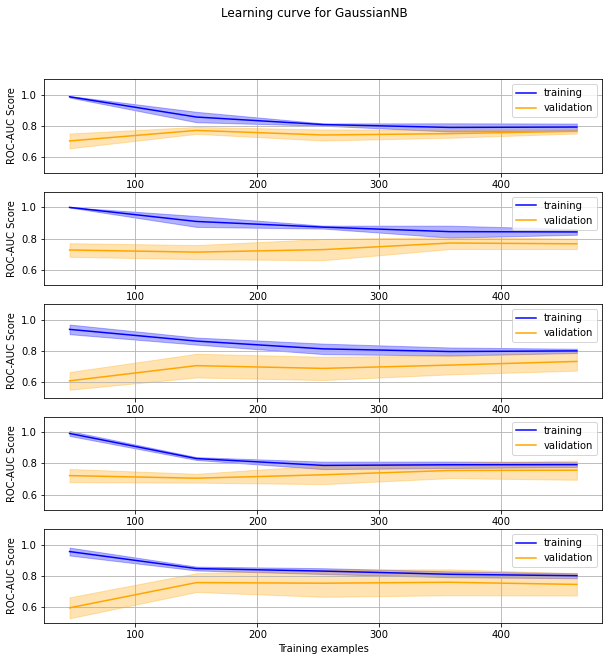

In [10]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_nb = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_nb = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('select', selector), ("nbayes", naive_bayes)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150)

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter= 20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_nb.append(search)

    # Evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_nb['f1'] += [f1_score(y_test, y_pred)]
    scores_nb['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_nb['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_nb[f'probs_split_{i+1}'] = y_score
    scores_nb[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

#### Training-Testing using Standard Scaler and PCA (hidden)
Performance for this pipeline was less compared to using the k-best feature selection (above).

In [ ]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_nb = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_nb = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("nbayes", naive_bayes)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150)

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter= 20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_nb.append(search)

    # Evaluation
    y_pred = best_clf.predict(X_test)
    scores_nb['f1'] += [f1_score(y_test, y_pred)]
    scores_nb['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_nb['AUC'] += [roc_auc_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [11]:
print('F1-scores:')
print(f"{scores_nb['f1']}, mean: {np.mean(scores_nb['f1'])}, std: {np.std(scores_nb['f1'])}")
print('Accuracy:')
print(f"{scores_nb['accuracy']}, mean: {np.mean(scores_nb['accuracy'])}, std: {np.std(scores_nb['accuracy'])}")
print('AUC:')
print(f"{scores_nb['AUC']}, mean: {np.mean(scores_nb['AUC'])}, std: {np.std(scores_nb['AUC'])}")

F1-scores:
[0.30769230769230765, 0.4444444444444444, 0.3283582089552239, 0.44444444444444453, 0.3733333333333333], mean: 0.3796545477739508, std: 0.05700052200975785
Accuracy:
[0.7831325301204819, 0.8393574297188755, 0.8192771084337349, 0.8192771084337349, 0.8112449799196787], mean: 0.8144578313253013, std: 0.018210094857437173
AUC:
[0.7241685144124169, 0.765410199556541, 0.7661862527716187, 0.7532150776053215, 0.7405764966740576], mean: 0.749911308203991, std: 0.015911219215318184


### Results - Hyperparameter search

In [12]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_nb): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
17,0.168360,36,0.000008,"{'select__k': 36, 'nbayes__var_smoothing': 8.1...",0.512788,0.100739,1
6,0.160969,38,0.0,"{'select__k': 38, 'nbayes__var_smoothing': 1.2...",0.501689,0.097685,2
4,0.160172,13,0.000658,"{'select__k': 13, 'nbayes__var_smoothing': 0.0...",0.497159,0.115488,3
16,0.209064,13,0.0,"{'select__k': 13, 'nbayes__var_smoothing': 1.5...",0.492858,0.109332,4
8,0.166953,51,0.000152,"{'select__k': 51, 'nbayes__var_smoothing': 0.0...",0.490568,0.086573,5


Results for split 2:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
13,0.191696,69,0.0,"{'select__k': 69, 'nbayes__var_smoothing': 1.5...",0.426842,0.079225,1
0,0.169141,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.423181,0.076878,2
2,0.160770,64,0.000534,"{'select__k': 64, 'nbayes__var_smoothing': 0.0...",0.422078,0.076068,3
10,0.193491,60,0.0,"{'select__k': 60, 'nbayes__var_smoothing': 5.3...",0.420691,0.060643,4
12,0.187300,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.420173,0.068959,5


Results for split 3:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
13,0.177325,69,0.0,"{'select__k': 69, 'nbayes__var_smoothing': 1.5...",0.459984,0.113166,1
2,0.186906,64,0.000534,"{'select__k': 64, 'nbayes__var_smoothing': 0.0...",0.459550,0.108367,2
12,0.177126,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.456273,0.100909,3
7,0.166953,112,0.000351,"{'select__k': 112, 'nbayes__var_smoothing': 0....",0.453428,0.098669,4
8,0.208641,51,0.000152,"{'select__k': 51, 'nbayes__var_smoothing': 0.0...",0.450525,0.110976,5


Results for split 4:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
0,0.175526,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.479324,0.072184,1
16,0.164957,13,0.0,"{'select__k': 13, 'nbayes__var_smoothing': 1.5...",0.470520,0.062894,2
4,0.208234,13,0.000658,"{'select__k': 13, 'nbayes__var_smoothing': 0.0...",0.462111,0.063007,3
15,0.174553,117,0.0,"{'select__k': 117, 'nbayes__var_smoothing': 1....",0.449929,0.037360,4
10,0.192891,60,0.0,"{'select__k': 60, 'nbayes__var_smoothing': 5.3...",0.446805,0.047129,5


Results for split 5:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
0,0.182116,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.479458,0.140189,1
4,0.169569,13,0.000658,"{'select__k': 13, 'nbayes__var_smoothing': 0.0...",0.463929,0.152114,2
16,0.162154,13,0.0,"{'select__k': 13, 'nbayes__var_smoothing': 1.5...",0.463929,0.152114,2
12,0.166749,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.459174,0.148794,4
15,0.183715,117,0.0,"{'select__k': 117, 'nbayes__var_smoothing': 1....",0.457776,0.149343,5


# K-Nearest Neighbours

#### Training-Testing using scaling and k-best feature selection

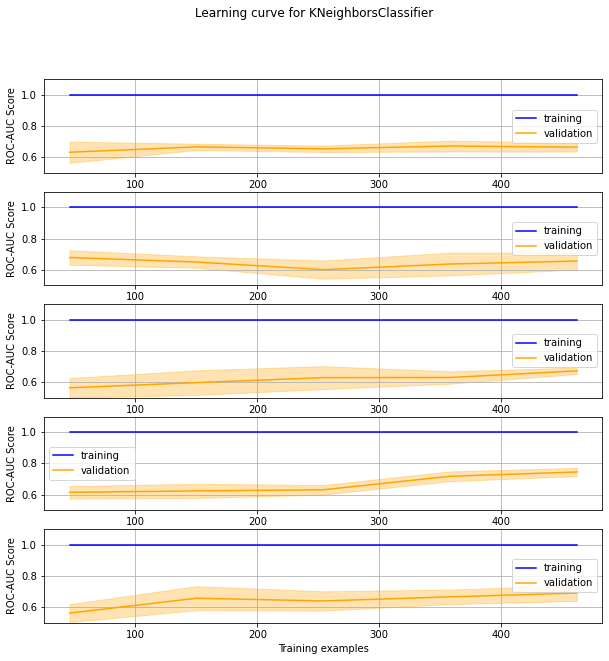

In [13]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_knn = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_knn = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    knn = KNeighborsClassifier()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('select', selector), ("knn", knn)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    k_range = list(range(1, 31))
    weights = ['uniform', 'distance']
    k_select = np.arange(2, 150)

    random_grid = {'knn__n_neighbors': k_range,
    'knn__weights': weights,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_knn.append(search)
    
    # evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_knn['f1'] += [f1_score(y_test, y_pred)]
    scores_knn['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_knn['AUC'] += [roc_auc_score(y_test, y_score[:,1])]
    
    # Predictions
    scores_knn[f'probs_split_{i+1}'] = y_score
    scores_knn[f'labels_split_{i+1}'] = list(y_test)

    plot_learning_curve(best_clf, X_train, y_train, axs[i]) # eventueel testen met groot aantal neighbors
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

#### Training-Testing using Standard Scaler and PCA (hidden)
Performance for this pipeline was less compared to using the k-best feature selection (above).

In [ ]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_knn = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_knn = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    knn = KNeighborsClassifier()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("knn", knn)])

    # GridSearch

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    k_range = list(range(1, 31))
    weights = ['uniform', 'distance']
    k_select = np.arange(2, 150)

    random_grid = {'knn__n_neighbors': k_range,
    'knn__weights': weights,
    'pca__n_components': pca_components}
    #'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_knn.append(search)
    
    # evaluation
    y_pred = best_clf.predict(X_test)
    scores_knn['f1'] += [f1_score(y_test, y_pred)]
    scores_knn['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_knn['AUC'] += [roc_auc_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i]) # eventueel testen met groot aantal neighbors
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [14]:
print('F1-scores:')
print(f"{scores_knn['f1']}, mean: {np.mean(scores_knn['f1'])}, std: {np.std(scores_knn['f1'])}")
print('Accuracy:')
print(f"{scores_knn['accuracy']}, mean: {np.mean(scores_knn['accuracy'])}, std: {np.std(scores_knn['accuracy'])}")
print('AUC:')
print(f"{scores_knn['AUC']}, mean: {np.mean(scores_knn['AUC'])}, std: {np.std(scores_knn['AUC'])}")

F1-scores:
[0.3116883116883117, 0.3283582089552239, 0.2711864406779661, 0.33333333333333326, 0.2816901408450704], mean: 0.305251287099981, std: 0.02481736415668658
Accuracy:
[0.7871485943775101, 0.8192771084337349, 0.8273092369477911, 0.8072289156626506, 0.7951807228915663], mean: 0.8072289156626506, std: 0.014810513184406224
AUC:
[0.6439024390243903, 0.6635809312638582, 0.65, 0.6589800443458981, 0.6277161862527717], mean: 0.6488359201773837, std: 0.012586151804688072


### Results - Hyperparameter search

In [15]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_knn): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.299398,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.398250,0.058986,1
1,0.258095,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.368535,0.113827,2
17,0.237764,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.336844,0.069839,3
10,0.259928,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.325245,0.077437,4
11,0.293827,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.310378,0.100797,5


Results for split 2:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.251549,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.342832,0.102430,1
11,0.281678,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.265627,0.101255,2
17,0.227392,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.264360,0.110648,3
1,0.268306,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.262788,0.115191,4
10,0.269693,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.228248,0.069688,5


Results for split 3:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
11,0.282067,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.374842,0.075753,1
1,0.259940,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.314156,0.060254,2
10,0.249154,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.280127,0.085020,3
6,0.248358,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.268780,0.103592,4
17,0.256725,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.189524,0.107176,5


Results for split 4:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.280077,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.527912,0.071456,1
11,0.274488,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.451037,0.079359,2
1,0.281249,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.379505,0.120906,3
10,0.258919,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.363597,0.084596,4
17,0.251152,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.321407,0.071497,5


Results for split 5:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.274104,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.403081,0.084473,1
17,0.246349,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.400906,0.106123,2
11,0.284079,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.386905,0.159652,3
1,0.263314,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.307207,0.147553,4
10,0.264296,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.276480,0.087488,5


# SVM

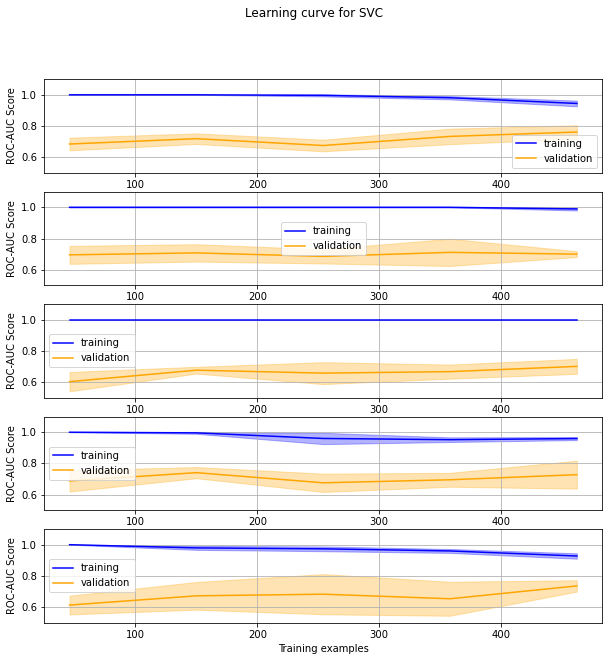

In [16]:
# Aantal splits
N_SPLITS = 5

rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_svm = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_svm = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    pca = PCA()
    selector = SelectKBest()

    # classifier 
    classifier = svm.SVC(probability=True)
    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('select', selector), ('svm', classifier)])

    # GridSearch

    # Random grid:
    random_grid = {
        #'pca__n_components': [None, 10,50,100],
            'svm__C': list(np.arange(0.01,100, 5)),
            'svm__gamma': list(np.arange(0.001, 1, 0.05)), 
            'svm__kernel': ['rbf', 'poly', 'linear'],
            #'pca__n_components': [None] + list(np.arange(1, 101, 20))} 
            'select__k': np.arange(2, 150)}

    search = RandomizedSearchCV(pipe, random_grid, cv=5, scoring = 'f1', n_iter= 20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_svm.append(search)

    # evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_svm['f1'] += [f1_score(y_test, y_pred)]
    scores_svm['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_svm['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_svm[f'probs_split_{i+1}'] = y_score
    scores_svm[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [17]:
print('F1-scores:')
print(f"{scores_svm['f1']}, mean: {np.mean(scores_svm['f1'])}, std: {np.std(scores_svm['f1'])}")
print('Accuracy:')
print(f"{scores_svm['accuracy']}, mean: {np.mean(scores_svm['accuracy'])}, std: {np.std(scores_svm['accuracy'])}")
print('AUC:')
print(f"{scores_svm['AUC']}, mean: {np.mean(scores_svm['AUC'])}, std: {np.std(scores_svm['AUC'])}")

F1-scores:
[0.39506172839506176, 0.46511627906976744, 0.4533333333333333, 0.3888888888888889, 0.3333333333333333], mean: 0.4071467126040769, std: 0.04779431870028478
Accuracy:
[0.8032128514056225, 0.8152610441767069, 0.8353413654618473, 0.8232931726907631, 0.8232931726907631], mean: 0.8200803212851406, std: 0.010595105187367795
AUC:
[0.6985587583148559, 0.7124168514412417, 0.7419068736141906, 0.688470066518847, 0.6961197339246119], mean: 0.7074944567627494, std: 0.01886585727432827


### Results - Hyperparameter search

In [18]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_svm): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
3,3.090132,linear,0.201,40.01,88,"{'svm__kernel': 'linear', 'svm__gamma': 0.201,...",0.527211,0.065624,1
8,0.434464,linear,0.401,20.01,142,"{'svm__kernel': 'linear', 'svm__gamma': 0.401,...",0.512008,0.036476,2
18,8.996727,linear,0.551,75.01,51,"{'svm__kernel': 'linear', 'svm__gamma': 0.551,...",0.507844,0.052504,3
13,0.296199,rbf,0.051,35.01,15,"{'svm__kernel': 'rbf', 'svm__gamma': 0.0510000...",0.506053,0.084841,4
4,2.829399,linear,0.951,85.01,101,"{'svm__kernel': 'linear', 'svm__gamma': 0.9510...",0.486498,0.042046,5


Results for split 2:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
1,0.817200,linear,0.751,35.01,124,"{'svm__kernel': 'linear', 'svm__gamma': 0.751,...",0.461328,0.042179,1
8,0.564466,linear,0.401,20.01,142,"{'svm__kernel': 'linear', 'svm__gamma': 0.401,...",0.454141,0.090406,2
0,2.932084,linear,0.601,60.01,103,"{'svm__kernel': 'linear', 'svm__gamma': 0.6010...",0.451951,0.072011,3
6,0.277542,poly,0.751,70.01,47,"{'svm__kernel': 'poly', 'svm__gamma': 0.751, '...",0.445415,0.065602,4
2,0.308381,poly,0.851,90.01,111,"{'svm__kernel': 'poly', 'svm__gamma': 0.851000...",0.441725,0.096498,5


Results for split 3:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
2,0.365768,poly,0.851,90.01,111,"{'svm__kernel': 'poly', 'svm__gamma': 0.851000...",0.468302,0.115042,1
1,1.232352,linear,0.751,35.01,124,"{'svm__kernel': 'linear', 'svm__gamma': 0.751,...",0.441807,0.059765,2
0,4.444128,linear,0.601,60.01,103,"{'svm__kernel': 'linear', 'svm__gamma': 0.6010...",0.432949,0.048785,3
8,0.644887,linear,0.401,20.01,142,"{'svm__kernel': 'linear', 'svm__gamma': 0.401,...",0.415321,0.019804,4
4,5.691963,linear,0.951,85.01,101,"{'svm__kernel': 'linear', 'svm__gamma': 0.9510...",0.402417,0.042387,5


Results for split 4:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
13,0.280245,rbf,0.051,35.01,15,"{'svm__kernel': 'rbf', 'svm__gamma': 0.0510000...",0.485307,0.063828,1
10,10.516420,linear,0.751,90.01,95,"{'svm__kernel': 'linear', 'svm__gamma': 0.751,...",0.465789,0.067647,2
0,5.083399,linear,0.601,60.01,103,"{'svm__kernel': 'linear', 'svm__gamma': 0.6010...",0.457657,0.062196,3
4,5.611995,linear,0.951,85.01,101,"{'svm__kernel': 'linear', 'svm__gamma': 0.9510...",0.439807,0.045201,4
18,9.737764,linear,0.551,75.01,51,"{'svm__kernel': 'linear', 'svm__gamma': 0.551,...",0.435709,0.098560,5


Results for split 5:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
13,0.287230,rbf,0.051,35.01,15,"{'svm__kernel': 'rbf', 'svm__gamma': 0.0510000...",0.487429,0.089706,1
18,11.654230,linear,0.551,75.01,51,"{'svm__kernel': 'linear', 'svm__gamma': 0.551,...",0.454439,0.086835,2
14,1.785040,linear,0.801,20.01,36,"{'svm__kernel': 'linear', 'svm__gamma': 0.801,...",0.424188,0.049030,3
8,0.620947,linear,0.401,20.01,142,"{'svm__kernel': 'linear', 'svm__gamma': 0.401,...",0.419535,0.080942,4
10,8.769158,linear,0.751,90.01,95,"{'svm__kernel': 'linear', 'svm__gamma': 0.751,...",0.412090,0.065468,5


# Statistical analysis

### Create table of p-values (significant values are green)

In [19]:
classifiers_used = ['Random Forest', 'K-NN', 'Naive Bayes', 'SVM']

names = combinations(classifiers_used, 2)
#comb = combinations([scores_rf['f1'], scores_knn['f1'], scores_nb['f1'], scores_svm['f1']], 2)

# Terugveranderen!
#scores_rf = [0.25925925925925924, 0.37931034482758624, 0.18518518518518517, 0.1923076923076923, 0.22222222222222218]
#scores_knn = [0.3, 0.3157894736842105, 0.30508474576271183, 0.3333333333333333, 0.2857142857142857]
#scores_nb = [0.30769230769230765, 0.41666666666666663, 0.34375, 0.4266666666666667, 0.3684210526315789]
#scores_svm = [0.393939393939394, 0.5000000000000001, 0.4594594594594595, 0.43076923076923074, 0.47619047619047616]

comb = combinations([scores_rf['f1'], scores_knn['f1'], scores_nb['f1'], scores_svm['f1']], 2)

# Print the obtained combinations
p_values_table = pd.DataFrame(index=classifiers_used, columns=classifiers_used)

for name, scores in zip(list(names), list(comb)):
    _, p_value = ttest_ind(scores[0], scores[1])
    p_values_table[name[0]][name[1]] = p_value
    p_values_table[name[1]][name[0]] = p_value

In [20]:
def _color_green(val):
    color = 'grey' if val == '-' else ('green' if float(val) < 0.05 else 'black')
    return 'color: %s' % color

In [21]:
p_values_table = p_values_table.replace(pd.NA, '-')
p_values_table = p_values_table.style.applymap(_color_green)
display(p_values_table)

,Random Forest,K-NN,Naive Bayes,SVM
Random Forest,-,0.613059,0.303297,0.115489
K-NN,0.613059,-,0.043611,0.005356
Naive Bayes,0.303297,0.043611,-,0.480926
SVM,0.115489,0.005356,0.480926,-


#### Boxplot for F1-scores of the different ML algorithms used

Text(0.5, 1.0, 'Boxplot F1-scores on test sets')

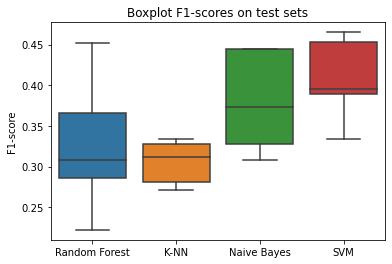

In [22]:
scores_df = pd.DataFrame({'Random Forest': scores_rf['f1'], 'K-NN': scores_knn['f1'], 'Naive Bayes': scores_nb['f1'], 'SVM': scores_svm['f1']})

ax = seaborn.boxplot(data=scores_df)
ax.set_ylabel('F1-score')
ax.set_title('Boxplot F1-scores on test sets')

C:\Users\koenk\AppData\Local\Temp\ipykernel_21352\3982617571.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


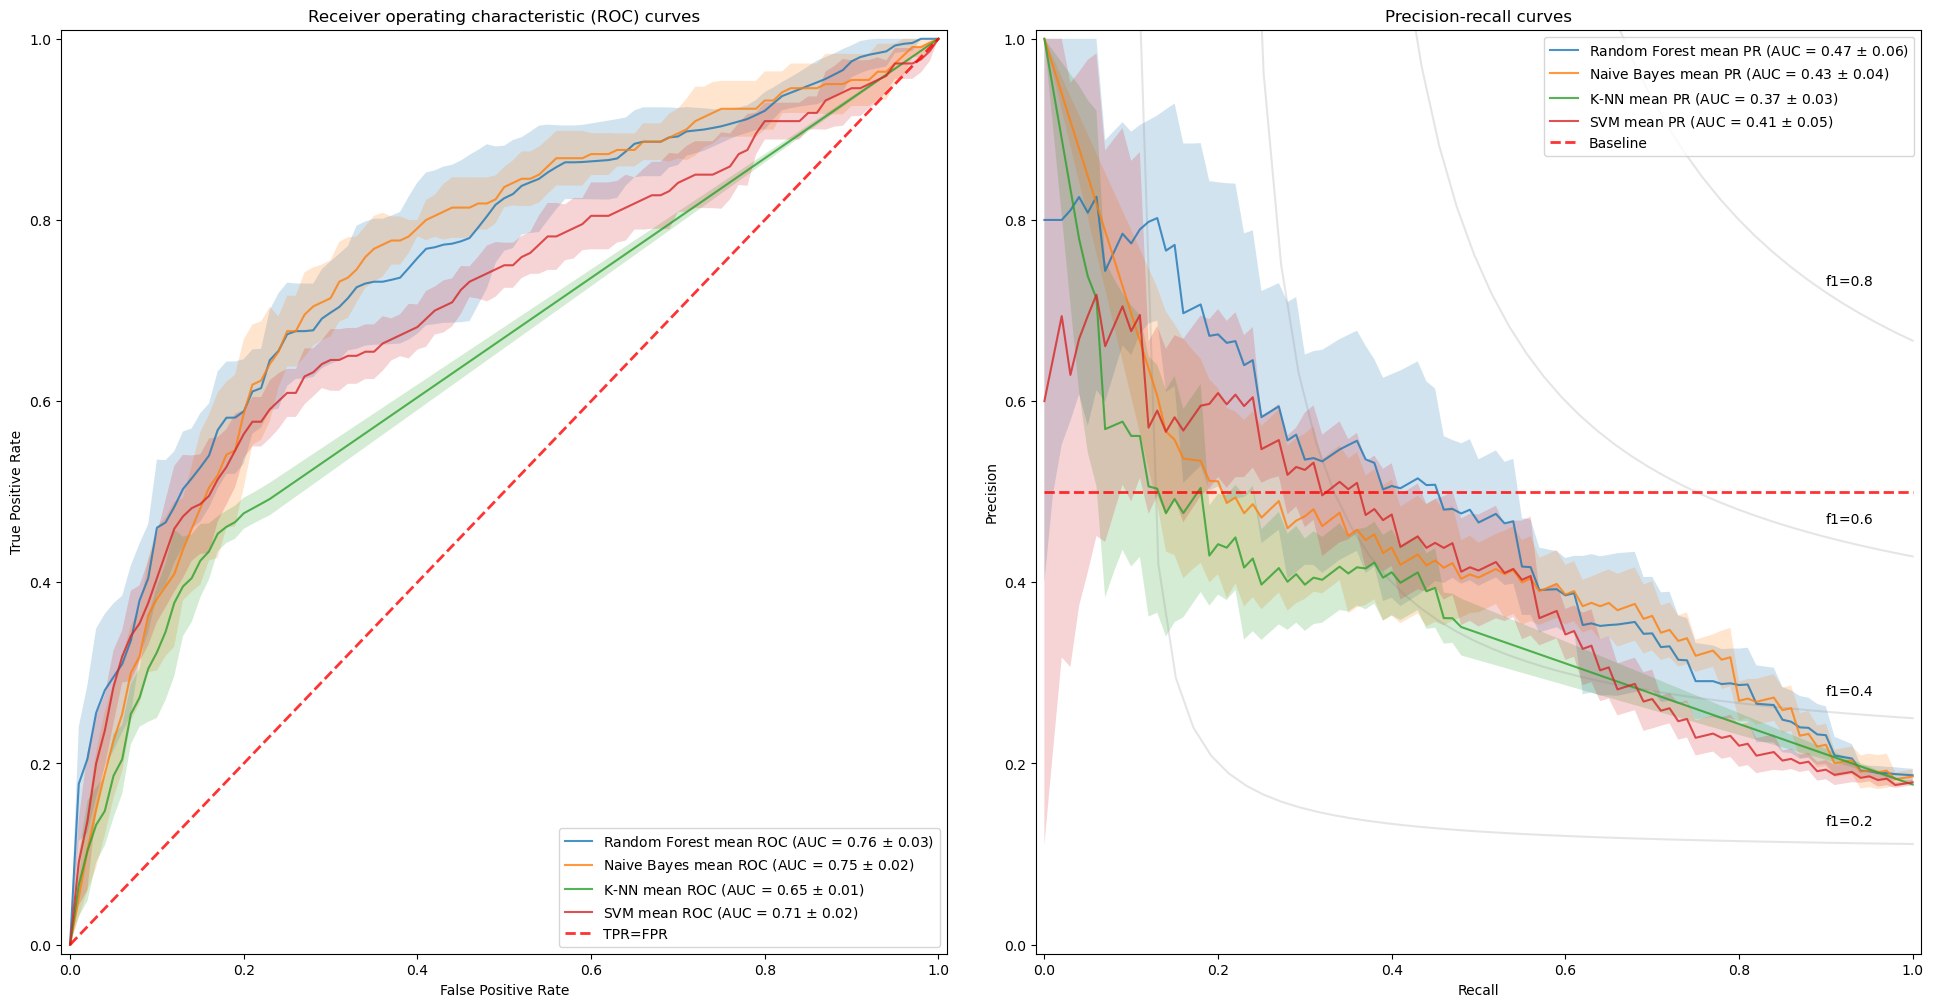

In [23]:
# Code adapted from:
# https://stackoverflow.com/questions/51442818/average-roc-curve-across-folds-for-multi-class-classification-case-in-sklearn

plt.style.use('default')

scores_dict = [scores_rf, scores_nb, scores_knn, scores_svm]
classifiers_used = ['Random Forest', 'Naive Bayes', 'K-NN', 'SVM']

colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

for dict, name in zip(scores_dict, classifiers_used):
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(N_SPLITS):
        fpr, tpr, _ = roc_curve(dict[f'labels_split_{i+1}'], dict[f'probs_split_{i+1}'][:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    axs[0].plot(base_fpr, mean_tprs, alpha = 0.8, label=r'%s mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),)
    axs[0].fill_between(base_fpr, tprs_lower, tprs_upper, alpha = 0.2)

axs[0].plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'TPR=FPR', alpha= 0.8)
axs[0].set_xlim([-0.01, 1.01])
axs[0].set_ylim([-0.01, 1.01])
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].legend(loc="lower right")
axs[0].set_title('Receiver operating characteristic (ROC) curves')
#plt.show()

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for dict, name in zip(scores_dict, classifiers_used):
    precision = []
    pr_auc = []
    base_recall = np.linspace(0, 1, 101)

    for i in range(N_SPLITS):
        prec, rec, _ = precision_recall_curve(dict[f'labels_split_{i+1}'], dict[f'probs_split_{i+1}'][:, 1])
        prec = np.flip(prec)
        rec = np.flip(rec)
        auc_temp = auc(rec, prec)
        pr_auc.append(auc_temp)
        prec = np.interp(base_recall, rec, prec)
        precision.append(prec)

    precision = np.array(precision)
    mean_precisions = np.mean(precision, axis=0)
    std = precision.std(axis=0)

    mean_auc = np.mean(pr_auc)
    std_auc = np.std(pr_auc)

    axs[1].plot(base_recall, mean_precisions, alpha = 0.8, label=r'%s mean PR (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),)
    

    prec_upper = np.minimum(mean_precisions + std, 1)
    prec_lower = mean_precisions - std
    axs[1].fill_between(base_recall, prec_lower, prec_upper, alpha = 0.2)

axs[1].plot([0, 1], [0.5, 0.5], linestyle = '--', lw = 2, color = 'r', label = 'Baseline', alpha= 0.8)
axs[1].set_xlim([-0.01, 1.01])
axs[1].set_ylim([-0.01, 1.01])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('Recall')
axs[1].legend(loc="upper right")
axs[1].set_title('Precision-recall curves')

plt.subplots_adjust(wspace=0.1, hspace=0)
#plt.tight_layout()
fig.show()

In [ ]:
#plt.figure(figsize=(12, 12))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for dict, name in zip(scores_dict, classifiers_used):
    precision = []
    pr_auc = []
    base_recall = np.linspace(0, 1, 101)

    for i in range(N_SPLITS):
        prec, rec, _ = precision_recall_curve(dict[f'labels_split_{i+1}'], dict[f'probs_split_{i+1}'][:, 1])
        prec = np.flip(prec)
        rec = np.flip(rec)
        auc_temp = auc(rec, prec)
        pr_auc.append(auc_temp)
        prec = np.interp(base_recall, rec, prec)
        precision.append(prec)

    precision = np.array(precision)
    mean_precisions = np.mean(precision, axis=0)
    std = precision.std(axis=0)

    mean_auc = np.mean(pr_auc)
    std_auc = np.std(pr_auc)

    axs[1].plot(base_recall, mean_precisions, alpha = 0.8, label=r'%s mean PR (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),)
    

    prec_upper = np.minimum(mean_precisions + std, 1)
    prec_lower = mean_precisions - std
    axs[1].fill_between(base_recall, prec_lower, prec_upper, alpha = 0.2)

axs[1].plot([0, 1], [0.5, 0.5], linestyle = '--', lw = 2, color = 'r', label = 'Baseline', alpha= 0.8)
axs[1].set_xlim([-0.01, 1.01])
axs[1].set_ylim([-0.01, 1.01])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('Recall')
axs[1].legend(loc="upper right")
axs[1].set_title('Precision-recall curves')

fig.show()